# Evaluation on MIMIC-CXR manual annotation

## Prepare

In [2]:
import sys
sys.path.append("../../src")
sys.path.append("../../../../git_clone_repos/fast-coref/src")

import os
import ast
from collections import Counter
import re

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display, HTML
from common_utils.coref_utils import ConllToken
# display(HTML(df.to_html()))

from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Event
from common_utils.data_loader_utils import load_mimic_cxr_bySection
from common_utils.coref_utils import resolve_mention_and_group_num
from common_utils.file_checker import FileChecker
from common_utils.common_utils import check_and_create_dirs, check_and_remove_dirs, check_and_remove_file
from coreference_resolution.data_preprocessing.mimic_cxr_csv2conll import copy_and_paste_conll
from common_utils.coref_socring import invoke_conll_script, resolve_conll_script_output

os.environ["TOKENIZERS_PARALLELISM"] = "false"

FILE_CHECKER = FileChecker()
START_EVENT = Event()

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def compute_conll_score(conll_file_gt, conll_file_pred):
    print("gt:", conll_file_gt)
    print("pred:", conll_file_pred)
    scorer_path = "./wrong_conll_scorer_example/reference-coreference-scorers/scorer.pl"
    overall_f1 = []
    for metric in ['muc', 'bcub', 'ceafe']:
        out, err = invoke_conll_script(scorer_path, metric, conll_file_gt, conll_file_pred)
        mention_recall, mention_precision, mention_f1, coref_recall, coref_precision, coref_f1 = resolve_conll_script_output(out)
        overall_f1.append(coref_f1)
        print(f"Metric: {metric}")
        print(f"mention_recall, mention_precision, mention_f1: {mention_recall}, {mention_precision}, {mention_f1}")
        print(f"coref_recall, coref_precision, coref_f1: {coref_recall}, {coref_precision}, {coref_f1}")

    print(f"Overall F1: {sum(overall_f1) / len(overall_f1)}")

In [4]:
def from_csv_to_conll(section_name, doc_id, output_file_path, input_file_path_or_df, coref_group_conll_colName, sentence_group_colName,token_colName):
    """ The whitespace tok contained in the csv file will be removed when being converted to conll file """
    BEGIN = f"#begin document ({doc_id}_{section_name}); part 0\n"
    SENTENCE_SEPARATOR = "\n"
    END = "#end document\n"

    # Resolve CSV file
    sentenc_list: list[list[ConllToken]] = []
    if isinstance(input_file_path_or_df, str):
        df = pd.read_csv(input_file_path_or_df, index_col=0, na_filter=False)
    else:
        df = input_file_path_or_df

    sentence_id = 0
    while True:
        token_list: list[ConllToken] = []
        df_sentence = df[df.loc[:, sentence_group_colName] == sentence_id].reset_index()
        if df_sentence.empty:
            break
        for _idx, data in df_sentence.iterrows():
            # Skip all whitespces like "\n", "\n " and " ".
            if str(data[token_colName]).strip() == "":
                continue
            conllToken = ConllToken(doc_id+"_"+section_name, sentence_id, _idx, data[token_colName])
            coref_col_cell = data[coref_group_conll_colName]
            if isinstance(coref_col_cell, str) and coref_col_cell != "-1":
                conllToken.add_coref_label("|".join(ast.literal_eval(coref_col_cell)))
            token_list.append(conllToken)
        sentenc_list.append(token_list)
        sentence_id += 1

    with open(output_file_path, "a", encoding="UTF-8") as out:
        out.write(BEGIN)
        for sent in sentenc_list:
            # Skip empty sentence
            if len(sent) == 1 and sent[0].tokenStr == "":
                continue
            for tok in sent:
                out.write(tok.get_conll_str() + "\n")
            out.write(SENTENCE_SEPARATOR)
        out.write(END)
        out.write("\n")

In [5]:
def from_list_to_conll(output_file_path, doc_id, section_name, old_sentenc_list):
    BEGIN = f"#begin document ({doc_id}_{section_name}); part 0\n"
    SENTENCE_SEPARATOR = "\n"
    END = "#end document\n"

    sentenc_list: list[list[ConllToken]] = []
    for sentence_id, old_token_list in enumerate(old_sentenc_list):
        token_list: list[ConllToken] = []
        for tok_idx, tok in enumerate(old_token_list):
            # Skip all whitespces like "\n", "\n " and " ".
            if tok.tokenStr.strip() == "":
                continue
            conllToken = ConllToken(doc_id+"_"+section_name, sentence_id, tok_idx, tok.tokenStr)
            conllToken.corefLabel = tok.corefLabel
            token_list.append(conllToken)
        sentenc_list.append(token_list)

    with open(output_file_path, "a", encoding="UTF-8") as out:
        out.write(BEGIN)
        for sent in sentenc_list:
            # Skip empty sentence
            if len(sent) == 1 and sent[0].tokenStr == "":
                continue
            for tok in sent:
                out.write(tok.get_conll_str() + "\n")
            out.write(SENTENCE_SEPARATOR)
        out.write(END)
        out.write("\n")

In [6]:
def remove_singleton(df_pred, coref_group_conll_colName):
    # remove singleton from df_pred
    corefGroup_counter = Counter()
    for conll_corefGroup_list_str in df_pred[~df_pred.loc[:, coref_group_conll_colName].isin(["-1", -1.0, np.nan])].loc[:, coref_group_conll_colName].to_list():
        for conll_corefGroup_str in ast.literal_eval(conll_corefGroup_list_str):
            result = re.search(r"(\d+)\)", conll_corefGroup_str)  # An coref mention always end with "number)"
            if result:
                corefGroup_counter.update([int(result.group(1))])

    non_singletone_counter: list[tuple] = list(filter(lambda item: item[1] > 1, corefGroup_counter.items()))
    coref_group_list_notSingleton = [int(k) for k, v in non_singletone_counter]
    
    # iter df rows, keep only the non_singleton coref id, and remove the others.
    for idx, item in df_pred.iterrows():
        conll_corefGroup_list_str = item.get(coref_group_conll_colName)
        new_conll_corefGroup_str_list = []
        # Remove singleton id
        if conll_corefGroup_list_str in ["-1", -1.0, np.nan]:
            continue
        for conll_corefGroup_str in ast.literal_eval(conll_corefGroup_list_str):
            res = re.match(r"\(?(\d+)\)?",conll_corefGroup_str)
            coref_group_id = int(res.groups()[0])
            if coref_group_id in coref_group_list_notSingleton:
                new_conll_corefGroup_str_list.append(conll_corefGroup_str)
        df_pred.loc[idx,coref_group_conll_colName] = str(new_conll_corefGroup_str_list) if new_conll_corefGroup_str_list else -1
    
    return df_pred

In [7]:
def format_input_tok_as_realworld(df_base, spacy_nametyle):
    """ 
    Format the input token without any additional processing. 
    For example, the whitespaces before and after sentences are all remained.
    """
    tok_list = df_base.loc[:, spacy_nametyle.token].to_list()
    sentGroup_list = df_base.loc[:, spacy_nametyle.sentence_group].to_list()
    sent_tok_2d_list: list[list[str]] = []
    for tok, sent_id in zip(tok_list, sentGroup_list):
        tok = str(tok)  # In i2b2, some of the tokens might incorrectly be recognized as float type.
        if len(sent_tok_2d_list) == sent_id:
            sent_tok_2d_list.append([tok])
        else:
            sent_tok_2d_list[sent_id].append(tok)
    return sent_tok_2d_list

def format_input_tok_same_as_traingset(df_base, spacy_nametyle):
    """ 
    Format the input token by using the same approach as creating training sets for fast-coref models 
    For example, we skipped all whitespces like "\n", "\n " and " ".
    """
    sent_tok_2d_list: list[list[str]] = []
    sentence_id = 0
    index_map= [] # map the input token index to the spacy token index.
    curr_spacy_index = 0
    while True:
        token_list2: list[str] = []
        df_sentence = df_base[df_base.loc[:, spacy_nametyle.sentence_group] == sentence_id].reset_index()
        if df_sentence.empty:
            break
        for _idx, data in df_sentence.iterrows():
            # Skip all whitespces like "\n", "\n " and " ".
            curr_spacy_index += 1
            if str(data[spacy_nametyle.token]).strip() == "":
                continue
            conllToken = data[spacy_nametyle.token]
            token_list2.append(conllToken)
            index_map.append(curr_spacy_index-1)
            
        sent_tok_2d_list.append(token_list2)
        sentence_id += 1
    return sent_tok_2d_list, index_map

In [8]:
def align_to_spacy(tok_indices_in_spacy, label_aligned_to_input, input_tok_list, spacy_tok_list):
    aligned_to_spacy_tok = [-1] * len(spacy_tok_list)
    for idx_in_spacy, label, input_tok in zip(tok_indices_in_spacy, label_aligned_to_input, input_tok_list):
        assert input_tok == spacy_tok_list[idx_in_spacy]
        aligned_to_spacy_tok[idx_in_spacy] = label
    return aligned_to_spacy_tok

In [9]:
### Modify this if gt file has changed###
output_dir = "../../resources/eval"
source_input_csv_dir = "../../output/mimic_cxr/manual_test_set/round1x2_new"
source_input_conll_dir = "../../output/mimic_cxr/coref/individual_conll_ground_truth/round1x2_new"

A list of gt docs

In [10]:
gt_dict_allDoc:dict[str,list] = {}
for section_name in ["findings","impression"]:
    gt_all_dir = os.path.join(source_input_csv_dir, section_name)
    gt_dict_allDoc[section_name] = [i.rstrip(".csv") for i in FILE_CHECKER.filter(os.listdir(gt_all_dir))]

A list of gt docs that has coref

In [11]:
gt_dict_hasCoref:dict[str,list] = {}
for section_name in ["findings","impression"]:
    gt_all_dir = os.path.join(source_input_conll_dir, section_name)
    gt_dict_hasCoref[section_name] = [i.rstrip(".conll") for i in FILE_CHECKER.filter(os.listdir(gt_all_dir))]

general gt conll file

The conll file is equivalent to the conll file used in fast-coref models

In [12]:
output_conll_file_gt = os.path.join(output_dir, "gt_200_noWhich_new.conll")
check_and_remove_file(output_conll_file_gt)
for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in doc_list:
        input_conll_file = os.path.join(source_input_conll_dir, section_name, f"{doc_id}.conll")
        if os.path.exists(input_conll_file):
            copy_and_paste_conll(input_conll_file, output_conll_file_gt)
        else:
            input_csv_file = os.path.join(source_input_csv_dir, section_name, f"{doc_id}.csv")
            from_csv_to_conll(section_name, doc_id, output_conll_file_gt, input_csv_file, "[gt]coref_group_conll", "[sp]sentence_group","[sp]token")

## Experiment 1-1: ensemble (majority voting)

### Binary Eval (has coref / no coref)

A list of predict docs that has coref

In [12]:
pred_dict_hasCoref: dict[str, list[str]] = {}
for section_name in ["findings","impression"]:
    ensemble_dir = os.path.join("../../output/mimic_cxr/coref/individual_conll", section_name)
    pred_dict_hasCoref[section_name] = [i.rstrip(".conll") for i in FILE_CHECKER.filter(os.listdir(ensemble_dir))]

In [13]:
true_positive = {}
false_positive = {} # predict true, actual false
false_negative = {} # predict false, actual true
true_negative = {}
for section_name in ["findings","impression"]:
    pred_hasCoref = set(pred_dict_hasCoref[section_name])
    gt_hasCoref = set(gt_dict_hasCoref[section_name])
    gt_all = set(gt_dict_allDoc[section_name])

    true_positive[section_name] = pred_hasCoref.intersection(gt_hasCoref)
    false_positive[section_name] = gt_all.intersection(pred_hasCoref) - gt_hasCoref
    false_negative[section_name] = gt_hasCoref - pred_hasCoref
    true_negative[section_name] = gt_all - pred_hasCoref

In [14]:
for section_name in ["findings","impression"]:
    print(section_name)
    print("true_positive",len(true_positive[section_name]))
    print("false_positive",len(false_positive[section_name]))
    print("false_negative",len(false_negative[section_name]))
    print("true_negative",len(true_negative[section_name]))

findings
true_positive 62
false_positive 0
false_negative 38
true_negative 38
impression
true_positive 62
false_positive 0
false_negative 38
true_negative 38


'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

'binary':
Only report results for the class specified by pos_label

In [16]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

y_true = ["has_coref" if doc_id in gt_dict_hasCoref[section_name] else "no_coref" for section_name, doc_list in gt_dict_allDoc.items() for doc_id in doc_list]
y_pred = ["has_coref" if doc_id in pred_dict_hasCoref[section_name] else "no_coref" for section_name, doc_list in gt_dict_allDoc.items() for doc_id in doc_list]
confusion_arr = confusion_matrix(y_true, y_pred, labels=["has_coref","no_coref"])
# TP FN
# FP TN
print(confusion_arr)
print()

micro_precision_recall_f1 = precision_recall_fscore_support(y_true, y_pred, average='micro')
macro_precision_recall_f1 = precision_recall_fscore_support(y_true, y_pred, average='macro')
weigthed_precision_recall_f1 = precision_recall_fscore_support(y_true, y_pred, average='weighted')
binary_precision_recall_f1 = precision_recall_fscore_support(y_true, y_pred, average=None, labels=["has_coref","no_coref"])
precision,recall,f1,support = binary_precision_recall_f1

print("precision, recall, f1, support(class_ele_num):")
print("micro:", micro_precision_recall_f1)
print("macro:", macro_precision_recall_f1)
print("weigthed macro:", weigthed_precision_recall_f1)
for i,j in zip(["has_coref","no_coref"],np.matrix([precision,recall,f1,support]).getT()):
    print("binary",i,j)

[[124  76]
 [  0   0]]

precision, recall, f1, support(class_ele_num):
micro: (0.62, 0.62, 0.62, None)
macro: (0.5, 0.31, 0.38271604938271603, None)
weigthed macro: (1.0, 0.62, 0.7654320987654321, None)
binary has_coref [[  1.          0.62        0.7654321 200.       ]]
binary no_coref [[0. 0. 0. 0.]]


/home/yuxiangliao/anaconda3/envs/sr_coref/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuxiangliao/anaconda3/envs/sr_coref/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yuxiangliao/anaconda3/envs/sr_coref/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

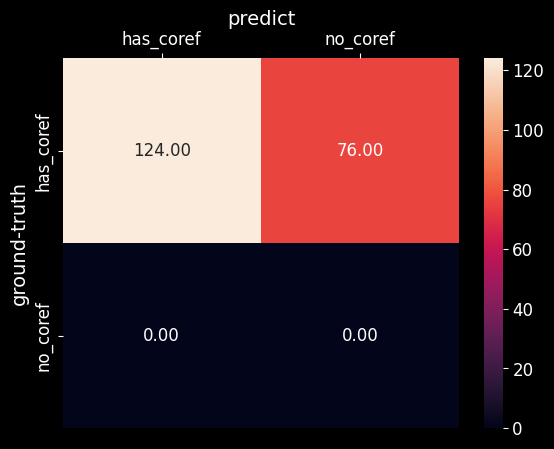

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure() #this creates a new figure on which your plot will appear
plt.tight_layout()

ax = sns.heatmap(confusion_arr, xticklabels=["has_coref", "no_coref"], yticklabels=["has_coref", "no_coref"], annot=True, fmt='.2f')

ax.set_xlabel('predict')
ax.set_ylabel('ground-truth')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

### CoNLL F1 Score

#### Only TP (42 doc)

In [19]:
output_conll_file_gt = os.path.join(output_dir, "gt_42_noWhich.conll")
output_conll_file_pred = os.path.join(output_dir, "pred_42.conll")
check_and_remove_file(output_conll_file_gt)
check_and_remove_file(output_conll_file_pred)
for section_name in ["findings","impression"]:
    for doc_id in true_positive[section_name]:
        # gt
        input_conll_file = os.path.join("../../output/mimic_cxr/coref/individual_conll_ground_truth", section_name, f"{doc_id}.conll")
        copy_and_paste_conll(input_conll_file, output_conll_file_gt)
        # pred
        input_conll_file = os.path.join("../../output/mimic_cxr/coref/individual_conll", section_name, f"{doc_id}.conll")
        copy_and_paste_conll(input_conll_file, output_conll_file_pred)

FileNotFoundError: [Errno 2] No such file or directory: '../../output/mimic_cxr/coref/individual_conll_ground_truth/findings/s54739969.conll'

In [ ]:
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

#### TP + FP (42+2), which is the ensemble application scenario

gt_44 (tp) + pred_44 (tp+fp)

In [ ]:
output_conll_file_gt = os.path.join(output_dir, "gt_44_noWhich.conll")
check_and_remove_file(output_conll_file_gt)
for section_name in ["findings","impression"]:
    doc_list = list(true_positive[section_name]) # false_positive files are not existing here, thus ignore
    for doc_id in doc_list:
        input_conll_file = os.path.join("../../output/mimic_cxr/coref/individual_conll_ground_truth", section_name, f"{doc_id}.conll")
        copy_and_paste_conll(input_conll_file, output_conll_file_gt)

output_conll_file_pred = os.path.join(output_dir, "pred_44.conll")
check_and_remove_file(output_conll_file_pred)
for section_name in ["findings","impression"]:
    doc_list = list(true_positive[section_name]) + list(false_positive[section_name])
    for doc_id in doc_list:
        input_conll_file = os.path.join("../../output/mimic_cxr/coref/individual_conll", section_name, f"{doc_id}.conll")
        copy_and_paste_conll(input_conll_file, output_conll_file_pred)

In [ ]:
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

### Experiment 100x: all (200), which is the actural conll scoring scenario.

1. Step 1: get fast_coref_xxx model outputs (csv files in /nlp_ensemble/temp_for_eval), then
2. Step 2: get majority_voting pipeline outputs (csv files in /coref_voting/temp_for_eval), then
3. Step 3: accordingly generate conll file and do evaluation

##### Step 1: Need to generate /nlp_ensemble/fast_coref_xxx csv files

In [23]:
sys.path.append("../../../../git_clone_repos/fast-coref/src")
from hydra import compose, initialize
from omegaconf import OmegaConf
from nlp_ensemble.nlp_menbers import play_fastcoref
from inference.tokenize_doc import tokenize_and_segment_doc
from nlp_ensemble.nlp_menbers.play_fastcoref import inference, resolve_output
from common_utils.nlp_utils import align_byIndex_individually_nestedgruop, align_coref_groups_in_conll_format

config = None
with initialize(version_base=None, config_path="../config", job_name="nlp_ensemble"):
        config = compose(config_name="nlp_ensemble", overrides=["+nlp_ensemble@_global_=mimic_cxr"])

# Init model
### Modify ###
model_dir = "../../../../git_clone_repos/fast-coref/models/coref_model_7a03/best"
config.fastcoref_joint.output_dir = "../../output/mimic_cxr/nlp_ensemble/temp_for_eval/fast_coref_7a03"

config.fastcoref_joint.model_dir = os.path.join(model_dir,"best") if os.path.exists(os.path.join(model_dir,"best")) else model_dir
model, subword_tokenizer, max_segment_len = play_fastcoref.init_coref_model(config)


spacy_nametyle = config.name_style.spacy.column_name
fastcoref_joint_nametyle = config.name_style.fastcoref_joint.column_name

# output_conll_file_pred = os.path.join(output_dir, "pred_joint_best.conll")
# check_and_remove_file(output_conll_file_pred)

for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in tqdm(doc_list):
        spacy_csv_file = os.path.join("../../output/mimic_cxr/nlp_ensemble/spacy", section_name, f"{doc_id}.csv")
        # Load preprocessed tokens from csv files.
        df_base = pd.read_csv(spacy_csv_file, index_col=0)
        sent_tok_2d_list, tok_indices_in_spacy = format_input_tok_same_as_traingset(df_base, spacy_nametyle)

        # Using longformer tokenizer to generate subtokens and form the input data.
        tokenized_doc = tokenize_and_segment_doc(sent_tok_2d_list, subword_tokenizer, max_segment_len=max_segment_len)

        # Get model output
        pred_mentions, mention_scores, gt_actions, pred_actions = inference(model, tokenized_doc)

        # Resolve model output
        coref_group_list = resolve_output(tokenized_doc, pred_mentions, pred_actions, ignore_singleton = True)
        
        # To dataframe
        spacy_tok_list = df_base.loc[:, spacy_nametyle.token].to_list()
        spacy_sentGroup_list = df_base.loc[:, spacy_nametyle.sentence_group].to_list()
        input_tok_list = [tok for sent in sent_tok_2d_list for tok in sent]
        
        coref_group_aligned_to_input_tok = align_byIndex_individually_nestedgruop(len(input_tok_list), coref_group_list)
        coref_group_aligned_to_spacy_tok = align_to_spacy(tok_indices_in_spacy, coref_group_aligned_to_input_tok, input_tok_list, spacy_tok_list)

        coref_group_conll_aligned_to_input_tok = align_coref_groups_in_conll_format(len(input_tok_list), coref_group_list)
        coref_group_conll_aligned_to_spacy_tok = align_to_spacy(tok_indices_in_spacy, coref_group_conll_aligned_to_input_tok, input_tok_list, spacy_tok_list)
        
        df_fastcoref_joint = pd.DataFrame(
            {
                fastcoref_joint_nametyle["token_from_spacy"]: [str(i) for i in spacy_tok_list],
                fastcoref_joint_nametyle["sentence_group"]: [int(i) for i in spacy_sentGroup_list],
                fastcoref_joint_nametyle["coref_group"]: [str(i) for i in coref_group_aligned_to_spacy_tok],
                fastcoref_joint_nametyle["coref_group_conll"]: [str(i) for i in coref_group_conll_aligned_to_spacy_tok],
            },
        )

        # Overwrite csv
        csv_output_dir = os.path.join(config.fastcoref_joint.output_dir, section_name)
        check_and_create_dirs(csv_output_dir)
        df_fastcoref_joint.to_csv(os.path.join(csv_output_dir, doc_id+".csv"))

Initializing model: ../../../../git_clone_repos/fast-coref/models/coref_model_7a03/best and doc_encoder: /home/yuxiangliao/PhD/workspace/git_clone_repos/fast-coref/models/longformer_coreference_joint


/home/yuxiangliao/anaconda3/envs/sr_coref/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


##### Step 2: Need to generate majority_voting gt (csv) files when only have fast_coref_xxx outputs (csv)

modify /config/coreference_resolution/coref_voting/mimic_cxr.yaml -> ${input.in_use}

In [19]:
from common_utils.coref_utils import shuffle_list
import coref_voting
from coref_voting import DocClass, MentionClass, compute_voting_result, get_output_df
from hydra import compose, initialize
from omegaconf import OmegaConf
from nlp_ensemble.nlp_menbers import play_fastcoref


config = None
with initialize(version_base=None, config_path="../config", job_name="majority_voting"):
        config = compose(config_name="coreference_resolution", overrides=["+coreference_resolution/coref_voting@_global_=mimic_cxr"])

### Modify. Also check /config/coreference_resolution/coref_voting/mimic_cxr.yaml -> ${input.in_use} ###
config.input.source.in_use = ["rb","fj","gt"] # ml, rb, fj, gt, fj_x, fj_x2
config.input.source.coref_models.fj_x.dir = "../../output/mimic_cxr/nlp_ensemble/temp_for_eval/fast_model_7a03"
config.input.source.coref_models.fj_x2.dir = "../../output/mimic_cxr/nlp_ensemble/temp_for_eval/fast_coref_best"
config.input.source.coref_models.gt.dir = "../../output/mimic_cxr/manual_test_set/round1x2_new"
mv_output_base_dir = os.path.join("../../output/mimic_cxr/coref_voting/temp_for_eval/rb_fj_gtnew")

def do_majority_voting(config, spacy_file_path, section_name, file_name):
    """ Voting on one document """

    START_EVENT.wait()

    # Read spacy output as alignment base
    df_spacy = pd.read_csv(spacy_file_path, index_col=0, na_filter=False)
    # Some of the i2b2 raw files are utf-8 start with DOM, but we didn't remove the DOM character, thus we fix it here.
    df_spacy.iloc[0] = df_spacy.iloc[0].apply(lambda x: x.replace("\ufeff", "").replace("\xef\xbb\xbf", "") if isinstance(x, str) else x)

    docObj: DocClass = coref_voting.resolve_voting_info(config, df_spacy, section_name, file_name)
    valid_mention_group: list[set[MentionClass]] = compute_voting_result(config, docObj)
    df_out = get_output_df(config, df_spacy, valid_mention_group, docObj)

    mv_output_dir = os.path.join(mv_output_base_dir, section_name)
    check_and_create_dirs(mv_output_dir)
    output_file_path = os.path.join(mv_output_dir, file_name)

    df_out.to_csv(output_file_path)

    return f"{file_name} done."

for section_name in ["findings","impression"]:
    with ProcessPoolExecutor(max_workers=config.thread.workers) as executor:
        all_task = []
        doc_list = gt_dict_allDoc[section_name]
        for doc_id in doc_list:
            file_name = doc_id + ".csv"
            spacy_out_dir = os.path.join(config.input.source.baseline_model.dir, section_name)
            spacy_file_path = os.path.join(spacy_out_dir, file_name)
            all_task.append(executor.submit(do_majority_voting, config, spacy_file_path, section_name, file_name))
        
         # Notify tasks to start
        START_EVENT.set()

        if all_task:
            for future in tqdm(as_completed(all_task), total=len(all_task)):
                msg = future.result()

        executor.shutdown(wait=True, cancel_futures=False)
        START_EVENT.clear()

100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


##### Step 3: Have majority_voting gt files already

In [20]:
### Modify ###
mv_output_base_dir = os.path.join("../../output/mimic_cxr/coref_voting/temp_for_eval/rb_fj_gtnew")

output_conll_file_pred = os.path.join(output_dir, "pred_mv.conll")
check_and_remove_file(output_conll_file_pred)
for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in doc_list:
        input_csv_file = os.path.join(mv_output_base_dir, section_name, f"{doc_id}.csv")
        from_csv_to_conll(section_name, doc_id, output_conll_file_pred, input_csv_file, "[mv]coref_group_conll", "[sp]sentence_group","[sp]token")

output_conll_file_gt = os.path.join(output_dir, "gt_200_noWhich_new.conll")
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

gt: ../../resources/eval/gt_200_noWhich_new.conll
pred: ../../resources/eval/pred_mv.conll
Metric: muc
mention_recall, mention_precision, mention_f1: 61.34, 94.55, 74.41
coref_recall, coref_precision, coref_f1: 58.87, 90.86, 71.45
Metric: bcub
mention_recall, mention_precision, mention_f1: 61.34, 94.55, 74.41
coref_recall, coref_precision, coref_f1: 58.76, 92.22, 71.79
Metric: ceafe
mention_recall, mention_precision, mention_f1: 61.34, 94.55, 74.41
coref_recall, coref_precision, coref_f1: 60.41, 92.99, 73.24
Overall F1: 72.16000000000001


## Experiment 1-2: scoref, dcoref, fast_coref_joint

In [30]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from nlp_ensemble.nlp_menbers import play_fastcoref

config = None
with initialize(version_base=None, config_path="../config", job_name="statistic"):
        config = compose(config_name="nlp_ensemble", overrides=["+statistic/coref_scoring@_global_=mimic_cxr"])

### Common way for testing scoref, dcoref, fast_coref_joint

scoref:(ml)
Metric: muc
mention_recall, mention_precision, mention_f1: 50.58, 70.32, 58.84
coref_recall, coref_precision, coref_f1: 42.67, 58.05, 49.19
Metric: bcub
mention_recall, mention_precision, mention_f1: 50.58, 70.32, 58.84
coref_recall, coref_precision, coref_f1: 44.61, 61.07, 51.56
Metric: ceafe
mention_recall, mention_precision, mention_f1: 50.58, 70.32, 58.84
coref_recall, coref_precision, coref_f1: 46.0, 65.65, 54.1
Overall F1: 51.61666666666667

dcoref (rb)
Metric: muc
mention_recall, mention_precision, mention_f1: 49.57, 59.95, 54.27
coref_recall, coref_precision, coref_f1: 38.31, 46.76, 42.12
Metric: bcub
mention_recall, mention_precision, mention_f1: 49.57, 59.95, 54.27
coref_recall, coref_precision, coref_f1: 41.24, 52.13, 46.05
Metric: ceafe
mention_recall, mention_precision, mention_f1: 49.57, 59.95, 54.27
coref_recall, coref_precision, coref_f1: 47.62, 56.98, 51.88
Overall F1: 46.68333333333333

fast_coref_joint:
Metric: muc
mention_recall, mention_precision, mention_f1: 61.17, 78.44, 68.74
coref_recall, coref_precision, coref_f1: 54.51, 70.0, 61.29
Metric: bcub
mention_recall, mention_precision, mention_f1: 61.17, 78.44, 68.74
coref_recall, coref_precision, coref_f1: 56.41, 72.82, 63.57
Metric: ceafe
mention_recall, mention_precision, mention_f1: 61.17, 78.44, 68.74
coref_recall, coref_precision, coref_f1: 59.96, 76.77, 67.33
Overall F1: 64.06333333333333

In [36]:
from common_utils.coref_socring import align_spacy_to_ground_truth, align_to_spacy, convert_non_spacy_token_csv_to_conll_format, convert_spacy_token_csv_to_conll_format, find_cloest_index

### Modify this ###
csv_file_dir = "../../output/mimic_cxr/nlp_ensemble/corenlp/dcoref"
model_cfg = config.input.source.models.get("rb") # ml -> scoref, rb -> dcoref, fj -> fast_coref_joint
model_cfg.dir = csv_file_dir
model_cfg.name = "dcoref"
output_conll_file_pred = os.path.join(output_dir, "pred_xxx.conll")

check_and_remove_file(output_conll_file_pred)
gt_cfg = config.input.ground_truth
scorer_cfg = config.scorer
spacy_cfg = config.input.spacy

for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in tqdm(doc_list):
        pred_file_path = os.path.join(csv_file_dir, section_name, f"{doc_id}.csv")
        df_pred = pd.read_csv(pred_file_path, index_col=0, na_filter=False)
        gt_file_path = os.path.join(source_input_csv_dir, section_name, f"{doc_id}.csv")
        df_gt = pd.read_csv(gt_file_path, index_col=0, na_filter=False)
        spacy_file_path = os.path.join("../../output/mimic_cxr/nlp_ensemble/spacy", section_name, f"{doc_id}.csv")
        df_spacy = pd.read_csv(spacy_file_path, index_col=0, na_filter=False)

        # Some of the i2b2 raw files are utf-8 start with DOM, but we didn't remove the DOM character, thus we fix it here.
        df_gt.iloc[0] = df_gt.iloc[0].apply(lambda x: x.replace("\ufeff", "").replace("\xef\xbb\xbf", "") if isinstance(x, str) else x)
        df_pred.iloc[0] = df_pred.iloc[0].apply(lambda x: x.replace("\ufeff", "").replace("\xef\xbb\xbf", "") if isinstance(x, str) else x)
        df_spacy.iloc[0] = df_spacy.iloc[0].apply(lambda x: x.replace("\ufeff", "").replace("\xef\xbb\xbf", "") if isinstance(x, str) else x)

        df_pred = remove_singleton(df_pred, model_cfg.target_column.coref_group_conll)

        # Generate conll format predicted files
        if model_cfg.align_to_spacy:

            # Algin to spacy first, then align spacy to gt
            model2spacy_tok_indices, coref_index_appearance_count_dict = align_to_spacy(config, model_cfg, df_spacy, df_pred)

            gt_token_list = df_gt.loc[:, gt_cfg.target_column.token_for_alignment].tolist()
            spacy_token_list = df_spacy.loc[:, spacy_cfg.target_column.token].tolist()
            spacy2gt_tok_indices, _ = align_spacy_to_ground_truth(gt_token_list, spacy_token_list)
            sentence_list_pred = convert_non_spacy_token_csv_to_conll_format(config, model_cfg, section_name, doc_id, coref_index_appearance_count_dict, model2spacy_tok_indices,
                                                                             spacy2gt_tok_indices, df_pred, df_spacy)
        else:
            # Directly align to ground-truth
            gt_token_list = df_gt.loc[:, gt_cfg.target_column.token_for_alignment].tolist()
            spacy_token_list = df_pred.loc[:, model_cfg.target_column.token].tolist()
            # Some token has conll label but does not exist in gt, that is what `empty_token_idx_with_conll_label_dict` is used for.
            spacy2gt_tok_indices, empty_token_idx_with_conll_label_dict = align_spacy_to_ground_truth(
                gt_token_list, spacy_token_list, df_spacy=df_spacy, spacy_cfg=spacy_cfg, df_pred=df_pred, model_cfg=model_cfg)
            target_token_index_and_conll_label_dict = find_cloest_index(spacy2gt_tok_indices, empty_token_idx_with_conll_label_dict)
            sentence_list_pred = convert_spacy_token_csv_to_conll_format(config, model_cfg, section_name, doc_id, spacy2gt_tok_indices, df_pred, target_token_index_and_conll_label_dict)


        # Write conll
        from_list_to_conll(output_conll_file_pred, doc_id, section_name, sentence_list_pred)

100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


In [37]:
### Modify this ###
output_conll_file_gt = os.path.join(output_dir, "gt_200_noWhich_new.conll")

compute_conll_score(output_conll_file_gt, output_conll_file_pred)

gt: ../../resources/eval/gt_200_noWhich_new.conll
pred: ../../resources/eval/pred_xxx.conll
Metric: muc
mention_recall, mention_precision, mention_f1: 49.57, 59.95, 54.27
coref_recall, coref_precision, coref_f1: 38.31, 46.76, 42.12
Metric: bcub
mention_recall, mention_precision, mention_f1: 49.57, 59.95, 54.27
coref_recall, coref_precision, coref_f1: 41.24, 52.13, 46.05
Metric: ceafe
mention_recall, mention_precision, mention_f1: 49.57, 59.95, 54.27
coref_recall, coref_precision, coref_f1: 47.62, 56.98, 51.88
Overall F1: 46.68333333333333


### Another way for testing fast_coref_joint

In [ ]:
### Modify this ###
_input_csv_source_dir = "../../output/mimic_cxr/nlp_ensemble/temp_for_eval/fast_coref_best"
_output_file_name = "pred_fjbest.conll"

gt_cfg = config.input.ground_truth
scorer_cfg = config.scorer
spacy_cfg = config.input.spacy

### Modify this with expected output name ###
output_conll_file_pred = os.path.join(output_dir, _output_file_name)
check_and_remove_file(output_conll_file_pred)
for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in doc_list:
        ### Modify this with correct csv file path ###
        input_csv_file = os.path.join(_input_csv_source_dir, section_name, f"{doc_id}.csv")
        df_pred = pd.read_csv(input_csv_file, index_col=0, na_filter=False)
        df_pred = remove_singleton(df_pred, "[fj]coref_group_conll")
        from_csv_to_conll(section_name, doc_id, output_conll_file_pred, df_pred, "[fj]coref_group_conll", "[fj]sentence_group","[fj]token_from_spacy")

### Modify this with correct ground_truth conll file ###
output_conll_file_gt = os.path.join(output_dir, "gt_200_noWhich.conll")
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

## Experiment 2: fine-tuned model

### init

In [ ]:
sys.path.append("../../../../git_clone_repos/fast-coref/src")
from hydra import compose, initialize
from omegaconf import OmegaConf
from nlp_ensemble.nlp_menbers import play_fastcoref

config = None
with initialize(version_base=None, config_path="../config", job_name="nlp_ensemble"):
        config = compose(config_name="nlp_ensemble", overrides=["+nlp_ensemble@_global_=mimic_cxr"])

In [ ]:
# Init model

### Modify ###
model_dir = "../../../../git_clone_repos/fast-coref/models/coref_joint_train_onto_i2b2_301/"
output_conll_file_pred = os.path.join(output_dir, "pred_model206.conll")

config.fastcoref_joint.model_dir = os.path.join(model_dir,"best") if os.path.exists(os.path.join(model_dir,"best")) else model_dir
model, subword_tokenizer, max_segment_len = play_fastcoref.init_coref_model(config)
check_and_remove_file(output_conll_file_pred)

Change the variable: model_dir and output_conll_file_pred with correct path.

In [ ]:
print("Using: ",config.fastcoref_joint.model_dir)

### Model is unstable when the input are slightly different

Simulate the real-world input

In [ ]:
# from inference.tokenize_doc import tokenize_and_segment_doc
# from model.utils import action_sequences_to_clusters
# from coref_utils.utils import get_mention_to_cluster,filter_clusters
# from nlp_ensemble.nlp_menbers.play_fastcoref import inference, resolve_output
# from common_utils.nlp_utils import align_byIndex_individually_nestedgruop, align_coref_groups_in_conll_format

# spacy_nametyle = config.name_style.spacy.column_name
# fastcoref_joint_nametyle = config.name_style.fastcoref_joint.column_name

# section_name = "impression"
# doc_id = "s51246808"

# spacy_csv_file = os.path.join("../../output/mimic_cxr/nlp_ensemble/spacy", section_name, f"{doc_id}.csv")
# # Load preprocessed tokens from csv files.
# df_base = pd.read_csv(spacy_csv_file, index_col=0)
# sent_tok_2d_list: list[list[str]] = format_input_tok_as_realworld(df_base, spacy_nametyle)

# # Using longformer tokenizer to generate subtokens and form the input data.
# tokenized_doc = tokenize_and_segment_doc(sent_tok_2d_list, subword_tokenizer, max_segment_len=max_segment_len)
# print(sent_tok_2d_list)

# # Get model output
# pred_mentions, mention_scores, gt_actions, pred_actions = inference(model, tokenized_doc)
# # Process predicted clusters
# raw_predicted_clusters = action_sequences_to_clusters(
#     pred_actions, pred_mentions
# )
# predicted_clusters = filter_clusters(
#     raw_predicted_clusters, threshold=2
# )
# mention_to_predicted = get_mention_to_cluster(predicted_clusters)

# for i in predicted_clusters:
#     print(i)

Equals to the traing data

In [ ]:
# spacy_nametyle = config.name_style.spacy.column_name
# fastcoref_joint_nametyle = config.name_style.fastcoref_joint.column_name

# section_name = "impression"
# doc_id = "s51246808"

# spacy_csv_file = os.path.join("../../output/mimic_cxr/nlp_ensemble/spacy", section_name, f"{doc_id}.csv")

# df_base = pd.read_csv(spacy_csv_file, index_col=0)
# sent_tok_2d_list: list[list[str]] = format_input_tok_same_as_traingset(df_base, spacy_nametyle)
    
# print(sent_tok_2d_list)

# # Using longformer tokenizer to generate subtokens and form the input data.
# tokenized_doc = tokenize_and_segment_doc(sent_tok_2d_list, subword_tokenizer, max_segment_len=max_segment_len)

# # Get model output
# pred_mentions, mention_scores, gt_actions, pred_actions = inference(model, tokenized_doc)
# # Process predicted clusters
# raw_predicted_clusters = action_sequences_to_clusters(
#     pred_actions, pred_mentions
# )
# predicted_clusters = filter_clusters(
#     raw_predicted_clusters, threshold=2
# )
# mention_to_predicted = get_mention_to_cluster(predicted_clusters)
# for i in predicted_clusters:
#     print(i)
    

### predict

In [ ]:
from inference.tokenize_doc import tokenize_and_segment_doc
from nlp_ensemble.nlp_menbers.play_fastcoref import inference, resolve_output
from common_utils.nlp_utils import align_byIndex_individually_nestedgruop, align_coref_groups_in_conll_format

spacy_nametyle = config.name_style.spacy.column_name
fastcoref_joint_nametyle = config.name_style.fastcoref_joint.column_name

# output_conll_file_pred = os.path.join(output_dir, "pred_joint_best.conll")
# check_and_remove_file(output_conll_file_pred)

for section_name in ["findings","impression"]:
    doc_list = gt_dict_allDoc[section_name]
    for doc_id in tqdm(doc_list):
        
        spacy_csv_file = os.path.join("../../output/mimic_cxr/nlp_ensemble/spacy", section_name, f"{doc_id}.csv")
        # Load preprocessed tokens from csv files.
        df_base = pd.read_csv(spacy_csv_file, index_col=0)
        sent_tok_2d_list, tok_indices_in_spacy = format_input_tok_same_as_traingset(df_base, spacy_nametyle)

        # Using longformer tokenizer to generate subtokens and form the input data.
        tokenized_doc = tokenize_and_segment_doc(sent_tok_2d_list, subword_tokenizer, max_segment_len=max_segment_len)

        # Get model output
        pred_mentions, mention_scores, gt_actions, pred_actions = inference(model, tokenized_doc)

        # Resolve model output
        coref_group_list = resolve_output(tokenized_doc, pred_mentions, pred_actions, ignore_singleton = True)
        
        # To dataframe
        spacy_tok_list = df_base.loc[:, spacy_nametyle.token].to_list()
        spacy_sentGroup_list = df_base.loc[:, spacy_nametyle.sentence_group].to_list()
        input_tok_list = [tok for sent in sent_tok_2d_list for tok in sent]
        
        coref_group_aligned_to_input_tok = align_byIndex_individually_nestedgruop(len(input_tok_list), coref_group_list)
        coref_group_aligned_to_spacy_tok = align_to_spacy(tok_indices_in_spacy, coref_group_aligned_to_input_tok, input_tok_list, spacy_tok_list)

        coref_group_conll_aligned_to_input_tok = align_coref_groups_in_conll_format(len(input_tok_list), coref_group_list)
        coref_group_conll_aligned_to_spacy_tok = align_to_spacy(tok_indices_in_spacy, coref_group_conll_aligned_to_input_tok, input_tok_list, spacy_tok_list)
        
        df_fastcoref_joint = pd.DataFrame(
            {
                fastcoref_joint_nametyle["token_from_spacy"]: [str(i) for i in spacy_tok_list],
                fastcoref_joint_nametyle["sentence_group"]: [int(i) for i in spacy_sentGroup_list],
                fastcoref_joint_nametyle["coref_group"]: [str(i) for i in coref_group_aligned_to_spacy_tok],
                fastcoref_joint_nametyle["coref_group_conll"]: [str(i) for i in coref_group_conll_aligned_to_spacy_tok],
            },
        )

        # Overwrite csv
        from_csv_to_conll(section_name, doc_id, output_conll_file_pred, df_fastcoref_joint, "[fj]coref_group_conll", "[fj]sentence_group","[fj]token_from_spacy")
        

eval:

If gt and pred conll files are existing, we can specify the path and run the following script directly.

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

output_conll_file_gt = os.path.join(output_dir, "gt_200_noWhich.conll")
# output_conll_file_pred = os.path.join(output_dir, "pred_model305.conll")
compute_conll_score(output_conll_file_gt, output_conll_file_pred)

## Another scorer

In [ ]:
import subprocess


output_conll_file_gt = os.path.join(output_dir, "gt_100_noWhich.conll")
output_conll_file_pred = os.path.join(output_dir, "pred_model204.conll")
scorer_path = "./wrong_conll_scorer_example/coval/scorer.py"
overall_f1 = []
command = ["python", scorer_path, output_conll_file_gt, output_conll_file_pred]

result = subprocess.run(command, capture_output=True, check=True)
out = result.stdout.decode('utf-8')
err = result.stderr.decode('utf-8')
print(out)